# Рекомендательная система на базе датасета **movielens**

Один из наиболее известных датасетов в мире рекомендательных систем - Movielens 25M, содержащий рейтинги к фильмам, оставленные различными пользователями на одноименном сайте https://movielens.org/.

Мы будем использовать мини-версию датасета, содержащую 100 тысяч записей рейтингов фильмов.

## Загрузка данных

Для создания алгоритмов рекомендательной системы, будем использовать библиотеку **surprise**.

Установим её, если она ещё не установлена на компьютер.

In [1]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163004 sha256=7b8485d173003c2409bd461cde85331d6189ad58058c3a8af5eded2a4f5a684f
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [2]:
from surprise import Dataset

Загружаем датасет из **surprise**

In [3]:
data = Dataset.load_builtin("ml-100k", prompt=False)

Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k


**Замечание для любителей настоящих данных**

Вы можете попробовать загрузить полную верисю датасета (`'ml-1m'`) и попробовать сделать задание на нём.

Но вычисления будут занимать большее количество времени (и требовать некоторого железа).

За использование расширенного датасета не будет бонусов в оценке (да и результатах по большей части тоже) - только ваш энтузиазм.

## Визуализация данных

Для удобной работы с данными загрузим библиотеку **pandas**

In [4]:
import pandas as pd

Преобразуем данные к формату **pandas DataFrame**, для удобной работы с ними:

In [5]:
df = pd.DataFrame(
    data.raw_ratings, columns=["userId", "movieId", "rating", "timestamp"]
)

In [6]:
df.head(10)

,userId,movieId,rating,timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596
5,298,474,4.0,884182806
6,115,265,2.0,881171488
7,253,465,5.0,891628467
8,305,451,3.0,886324817
9,6,86,3.0,883603013


*  Колонка **userId** - идентификаторы пользователей сайта movielens;
*  Колонка **movieId** - идентификаторы фильмов;
*  Колонка **rating** - оценки фильмов пользователями по шкале от 1 до 5;
*  Колонка **timestamp** - это время оценки фильма пользователем. Данный формат представления времени показывает, сколько секунд прошло с 1 января 1970 года.

Мы можем посмотреть, сколько уникальных значений находится в каждой из колонок.

In [7]:
df.apply("nunique")

userId         943
movieId       1682
rating           5
timestamp    49282
dtype: int64

Для корректной работы с графиками в python требуется загрузить специальную библиотеку
**matplotlib**, программную библиотеку на языке python для визуализации данных двумерной и трехмерной графикой.

Посмотрим наглядно, как часто в датасете встречаются разные оценки:

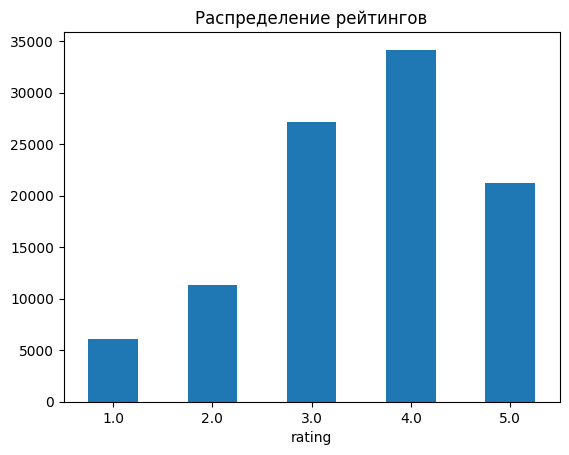

In [8]:
df["rating"].value_counts().sort_index().plot.bar(
    title="Распределение рейтингов", rot=0
);

## Разбиение выборки на обучающую и тестовую

Библиотека **surprise** высокоуровневая, и позволяет нам разбить данные на обучающую и тестовую выборки всего одной функцией **train_test_split()**

In [9]:
from surprise.model_selection import train_test_split

Функция **train_test_split()** принимает на вход два параметра:
*  **data** - данные
*  **test_size** - доля тестовой выборки. Укажем 0,25, чтобы тестовая выборка составляла 25% от всей выборки.

In [10]:
trainset, testset = train_test_split(data, test_size=0.25)

# Задание 1

Проведите исследование данных (exploratory data analysis, EDA).

Выясните:

1. Сколько оценок в среднем поставил один человек (и какова выборочная дисперсия этой величины)
2. Сколько оценок в среднем имеет один фильм (+дисперсия)

Также для каждой из этих величин постройте гистограму (или violin plot) распределения чтобы увидеть картину целиком. Возможно вам понадобится использовать логарифмический масштаб осей (эту настройку можно передать в matplotlib).

Mean 106.04453870625663
std 100.93174276633498
Median 65.0


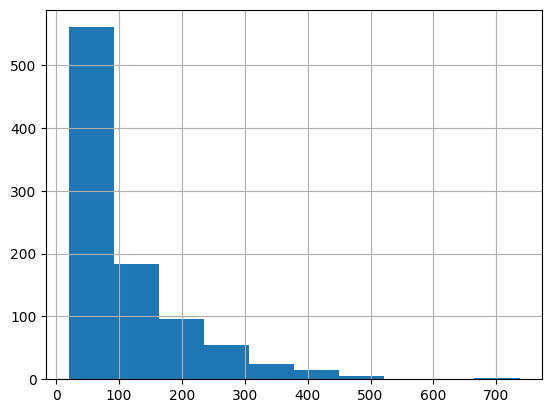

In [32]:
users = df.groupby("userId")["rating"].count()
print("Mean", users.mean())
print("std", users.std())
print("Median", users.median())
users.hist();

Mean 59.45303210463734
std 80.38384561004929
Median 27.0


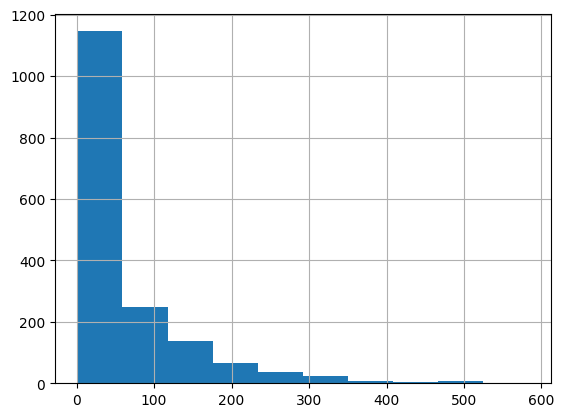

In [34]:
movies = df.groupby("movieId")["rating"].count()
print("Mean", movies.mean())
print("std", movies.std())
print("Median", movies.median())
movies.hist();

## Построение простой модели

In [20]:
from surprise import SVD, KNNBasic, accuracy

Инициализируем алгоритм. Алгоритм SVD - один из самых распространенных методов матричной факторизации (представления матрицы в виде произведения нескольких матриц). Такое представление позволяет анализировать похожие матрицы и раскладывать их на так называемые "компоненты". А так же, восстанавливая матрицы их этих компонент - заполнять недостающие значения (в нашем случае - оценки). Почитать можно здесь: http://www.albertauyeung.com/post/python-matrix-factorization/

In [21]:
algo = SVD()

Тренируем на тренировочной выборке алгоритм.

In [22]:
algo.fit(trainset)

Делаем предсказание на тестовой выборке.

In [23]:
predictions = algo.test(testset)

In [24]:
testset[:10]

[('537', '3', 2.0),
 ('686', '527', 3.0),
 ('379', '746', 3.0),
 ('474', '318', 5.0),
 ('782', '255', 4.0),
 ('256', '568', 5.0),
 ('119', '28', 5.0),
 ('474', '64', 5.0),
 ('387', '92', 4.0),
 ('405', '95', 3.0)]

In [25]:
accuracy.rmse(predictions);

RMSE: 0.9371


## Кросс-валидация

Обучая любой алгоритм машинного обучения мы, фактически, "подгоняем" модель под данные, которые ей подаём. Но, если подгонять слишком сильно, то модель переобучится. То есть модель начнёт запоминать ответы вместо того, чтобы выявлять закономерности.

На графиках ниже точки тренировочной выборки:
*  слева - недообученная модель (большая ошибка на тренировочной выборке; большая ошибка на тестовой выборке)
*  посередине - хорошо обученная модель (маленькая ошибка на тренировочной выборке; маленькая ошибка на тестовой выборке)
*  справа - переобученная модель (очень маленькая или нулевая ошибка на тренировочной выборке; большая ошибка на тестовой выборке)

<p align="center">
  <img src="https://drive.google.com/uc?id=1Eg4Xg4o-lhzrgqNNmNQCtB1RxNJmnmWx" alt="Drawing" style="width: 700px;" width="700"/>
</p>

Таким образом, обучая модель, мы всегда уменьшаем ошибку на тренировочной выборке. Вместе с ошибкой на тренировочной выборке, падает и ошибка на тестовой. Но после какого-то момента, модель начинает переобучатся, и ошибка на тестовой выборке начинает расти, в то время, как ошибка на тренировочной выборке продолжает падать.

<p align="center">
  <img src="https://drive.google.com/uc?id=1mvU_jJIe07tAoX82qODcpmTBctx0ReuT" alt="Drawing" style="width: 700px;" width="700"/>
</p>

Может получится ситуация, когда мы видим маленькую ошибку нашей модели, и думаем, что она хорошая, но на самом деле она просто переобучилась, и на новых данных покажет плохой результат.

Чтобы избежать такой ситуации можно использовать отложенную выборку. То есть мы разбиваем наши данные на **тренировочную** выборку, **тестовую** выборку и **отложенную** выборку. Соответственно, обучаем модель на тренировочной, в ходе обучения проверяем результат на тестовой выборке, а в конце обучения, чтобы оценить качество модели, ошибку считаем на отложенной выборке.

При таком подходе в обучении модели участвует только тренировочная выборка. Тестовую и отложенную мы используем только для проверки. Если у нас мало данных, отложенная выборка - непозволительная роскошь.

Другой популярный подход это **кросс-валидация** или скользящий контроль. Суть метода заключается в том, что мы дераем не одно разбиение датесета, а несколько разбиений таким образом, чтобы все данные использовались и в обучении и для проверки. Такие разбиения называются **фолдами**.

Преимущества такого подхожа в том, что мы используем все данные для обучения. Также это позволяет оценить устойчивость модели. Если ошибки полученные на разных фолдах сильно отличаются, что модель неустойчива.
Недостаток метода в том, что нам нужно обучать не одну модель, а несколько (столько, сколько мы выбрали фолдов).

На практике часто выбирают 5 фолдов.

<p align="center">
  <img src="https://drive.google.com/uc?id=1C9eHgCi30X08XaSScmjqIOT3ayBtBiFw" alt="Drawing" style="width: 500px;" width="300"/>
</p>

In [26]:
from surprise.model_selection import cross_validate

Используем функцию **cross_validate** из модуля **model_selection** библиотеки **surprise**.

Функция принимает на вход:
*  algo - алгоритм, который будем обучать.
*  data - исходные данные. Обратите внимание, что данные передаём не разбитые на выборки.
*  measures - метрики ошибок по которым мы хотим сравнивать модели. Мы передаём среднеквадратичную ошибку и среднюю ошибку.
* cv - количество фолдов.
*  verbose - параметр указывающий хотим ли мы увидеть подробный результат выполнения функции.

In [27]:
algo = SVD()
cross_validate(algo, data, measures=["RMSE", "MAE"], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9430  0.9279  0.9353  0.9363  0.9395  0.9364  0.0050  
MAE (testset)     0.7419  0.7317  0.7372  0.7391  0.7410  0.7382  0.0036  
Fit time          1.97    1.68    1.48    1.50    1.50    1.63    0.19    
Test time         0.17    0.15    0.15    0.17    0.48    0.22    0.13    


{'test_rmse': array([0.94297116, 0.9279094 , 0.93526078, 0.93631906, 0.93947508]),
 'test_mae': array([0.74191693, 0.731671  , 0.73720483, 0.73908611, 0.74100438]),
 'fit_time': (1.974339485168457,
  1.6797535419464111,
  1.478240966796875,
  1.5003767013549805,
  1.5012593269348145),
 'test_time': (0.17291045188903809,
  0.15194153785705566,
  0.1527869701385498,
  0.16635870933532715,
  0.4766199588775635)}

В результате получаем значения ошибок на каждом из фолдов, а также их среднее и стандартное отклонение (СО). Маленькое СО, как в нашем случае, говорит об устойчивости модели.

Дополнительно мы видим время тренировки и время предсказания модели на каждом из фолдов.

## Поиск по сетке (Grid search)

Теперь, когда у нас есть надёжный способ оценивать качество модели, мы можем перейти к подбору гиперпараметров модели, т.е. параметров, которые нужно указывать вручную, потому что нельзя обучить во время тренировки модели.

Метод поиска по сетке очень прост. Мы передаём варианты каждого из параметров, который мы хотим перебрать, а функция перебирает все возможные варианты переданных параметров. Например, на картинке ниже перебираются параметры "регуляризация" и "скорость обучения".

<p align="center">
  <img src="https://drive.google.com/uc?id=1xs9z_Zo1A2QinErKYEB-bp6eGnLWodbO" alt="Drawing" style="width: 700px;" width="700"/>
</p>

# Задание 2

## Часть 1

Оптимизируйте следующие параметры алгоритма SVD:

* n_epochs - количество эпох обучения
* lr_all - скорость обучения
* reg_all - регуляризация

Более детальное описание алгоритма смотри в [документации](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD)

P.S. не нужно делать слишком большую сетку перебора - если время расчёта отнимает больше 10 мин, то это уже очень много (для базового датасета).

In [28]:
from surprise.model_selection import GridSearchCV

Для перебора по сетке используем функцию **GridSearchCV**.
На вход подаём:
* алгоритм.
* параметры, которые хотим перебрать.
* метрики ошибок.
* количество фолдов для кросс-валидации.

Обратите внимание, что функция выполняет кросс-валидация автоматически.

In [35]:
params = {
    "n_epochs": [20, 30, 50],
    "lr_all": [0.001, 0.01, 0.05],
    "reg_all": [0.01, 0.1, 0.05],
}
grid = GridSearchCV(
    SVD,
    param_grid=params,
    measures=["rmse", "mae"],
    cv=3,
    n_jobs=-1,
    return_train_measures=True,
)
grid.fit(data)

In [39]:
grid.best_score, grid.best_params

({'rmse': 0.9201236697539286, 'mae': 0.7267910017142842},
 {'rmse': {'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.1},
  'mae': {'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.1}})

## Часть 2

Выберите другую модель из scikit surprise для предсказания рекомендаций (полный список смотри в [документации](https://surprise.readthedocs.io/en/stable/prediction_algorithms_package.html)).\
И настройте её параметры с помощью поиска по сетке.

Сравните результаты с предыдущей моделью.

In [40]:
params = {"k": [10, 20, 40], "min_k": [1, 2, 5]}
grid = GridSearchCV(
    KNNBasic,
    param_grid=params,
    measures=["rmse", "mae"],
    cv=3,
    n_jobs=-1,
    return_train_measures=True,
)
grid.fit(data)

In [41]:
grid.best_score, grid.best_params

({'rmse': 0.986702471386185, 'mae': 0.7795752854124958},
 {'rmse': {'k': 20, 'min_k': 2}, 'mae': {'k': 20, 'min_k': 2}})

In [44]:
knn_model = grid.best_estimator["rmse"]

# Задание 3

С помощью натренированной модели (любой из предыдущих) постройте по 3 рекомендации для каждого клиента из тестовой выборки.

Проанализируйте полученные результаты: сколько раз был порекомендован каждый фильм? Каково распределение этих частот? (постройте гистограму)

In [46]:
def get_top_n(predictions, n=3):
    """Returns top-n recommendatoins for each user from a set of predictions"""
    top_n = {}
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid] = top_n.get(uid, []) + [(iid, est)]

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [47]:
algo = SVD(lr_all=0.01, n_epochs=50, reg_all=0.1, random_state=42)
algo.fit(trainset)
preds = algo.test(testset)

In [49]:
top_n = get_top_n(preds, n=3)

In [54]:
all_recommends = []
for user_ratings in top_n.values():
    movies = [iid for (iid, _) in user_ratings]
    all_recommends += movies

unique_movies = set(all_recommends)
len(unique_movies)

424

In [55]:
freq_recommends = pd.Series(all_recommends).value_counts()
freq_recommends.head(10)

50     101
127     76
318     68
313     64
64      62
174     60
100     58
98      57
12      53
483     41
Name: count, dtype: int64

In [56]:
import matplotlib.pyplot as plt

<BarContainer object of 424 artists>

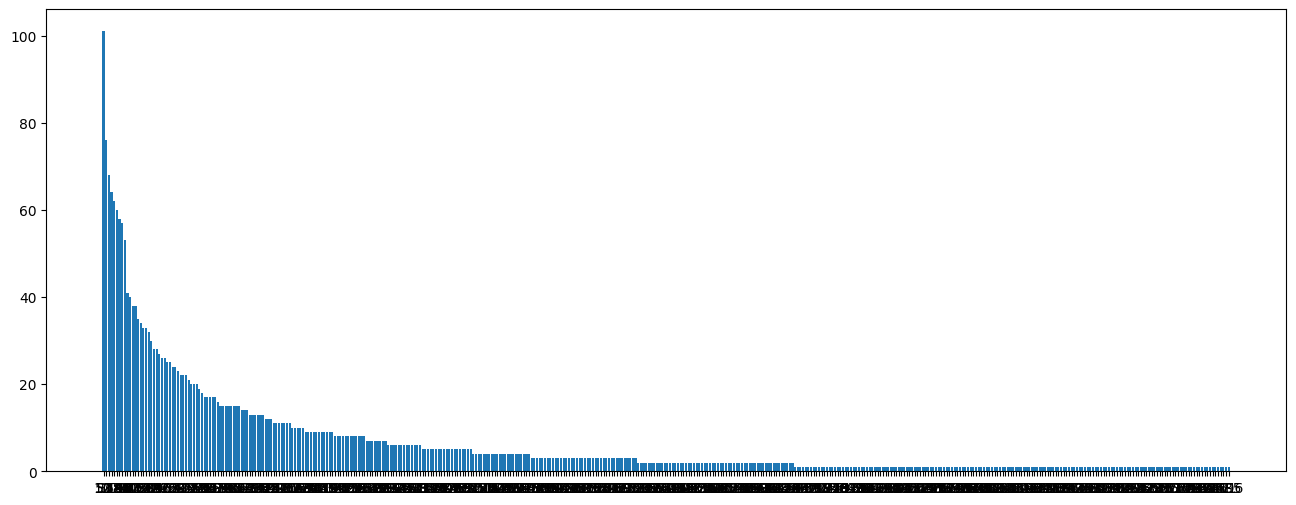

In [60]:
plt.figure(figsize=(16, 6))
plt.bar(freq_recommends.index, freq_recommends.values)

<BarContainer object of 30 artists>

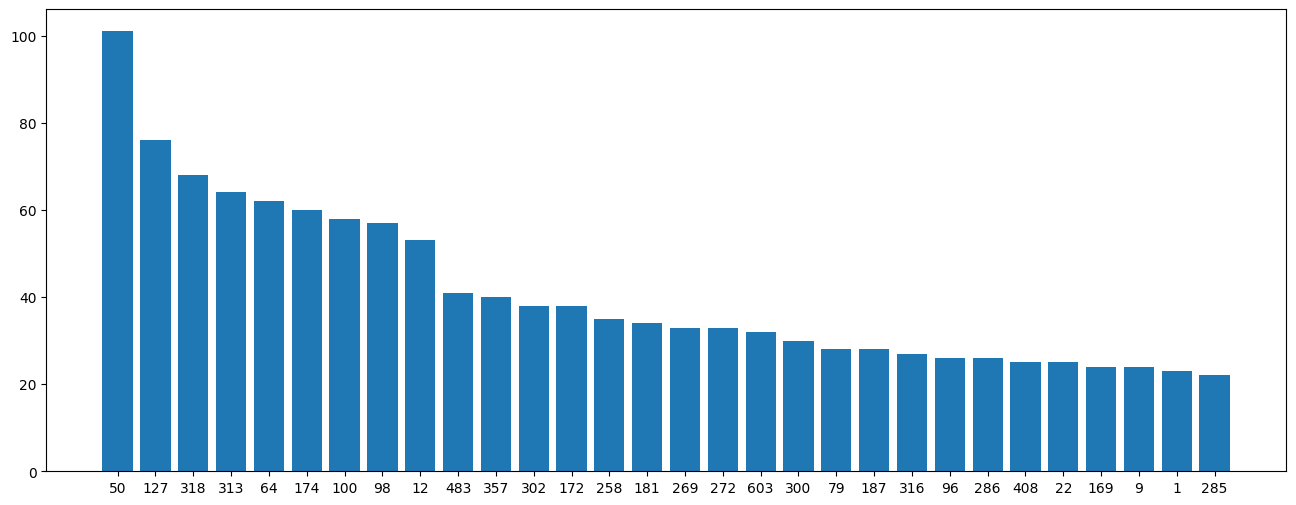

In [59]:
plt.figure(figsize=(16, 6))
plt.bar(freq_recommends.index[:30], freq_recommends.values[:30])